In [34]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
import pandas as pd
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim import corpora
from langdetect import detect_langs, LangDetectException
import os
import glob
import gc
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go  # Import plotly's graph objects
from typing import List, Union
from IPython.display import display, HTML
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [35]:
os.chdir('/Users/lhampton/Documents/Local_Projects/ailandscapeproject')

In [36]:
os.chdir('/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/constructed/wp_topic_modeling')
orig_dir = "/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/original/working_papers"
class_dir = "/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/constructed/wp_classification"

## Load the data

In [197]:
wp_data_both = pd.read_csv(f"{class_dir}/classed_wps_3.csv", index_col = 0).reset_index()
wp_data_As = wp_data_both[wp_data_both['GPT_class'] == "A"][['abstract']].drop_duplicates('abstract')
wp_data_full = pd.read_csv(f"{orig_dir}/working_papers.csv", index_col = 0).drop_duplicates('abstract')
wp_data_As = pd.merge(wp_data_As, wp_data_full, how = 'left', on = 'abstract')
print("length of base data: ", len(wp_data_As))

# add citations
wp_data_cits_dois = pd.read_csv(f"{orig_dir}/citations.csv", index_col=0).drop_duplicates(subset = ['doi'])
data = pd.merge(wp_data_As, wp_data_cits_dois, on = 'doi', how = 'left')

wp_data_cits_abstracts = pd.read_csv(f"{orig_dir}/citations_abstracts.csv", index_col=0).drop_duplicates(subset=['abstract'])
wp_data_cits_abstracts = wp_data_cits_abstracts.rename(columns = {'abstract' : 'abstract_short'}) # this contains only the first 500 letters of the abstract
data['abstract_short'] = data['abstract'].str[:500]
data = pd.merge(data, wp_data_cits_abstracts, on = 'abstract_short', how = 'left') 

data['Cited by'] = data['citation_count_x'].fillna(data['citation_count_y'])
data = data.drop(columns=['citation_count_x', 'citation_count_y'])

# drop duplicates, and drop abstracts with no citations
data = data.drop_duplicates('abstract')
data = data.dropna(subset = 'Cited by')
print("length of data with citations: ", len(data))
data

length of base data:  1200
length of data with citations:  1039


,abstract,title,author,doi,link,year,Source,ID,abstract_short,Cited by
0,Do stronger intellectual property rights incen...,do stronger ipr incentivize female participati...,"higgins, matthew j",10.3386/w32547,http://www.nber.org/papers/w32547.pdf,2024.0,NBER,4,Do stronger intellectual property rights incen...,0.0
1,Drawing insights from the field of innovation ...,"old moats for new models: openness, control, a...","nagaraj, abhishek",10.3386/w32474,http://www.nber.org/papers/w32474.pdf,2024.0,NBER,6,Drawing insights from the field of innovation ...,32.0
2,How will the emergence of ChatGPT and other fo...,artificial intelligence and the skill premium,"veruete, mario",10.3386/w32430,http://www.nber.org/papers/w32430.pdf,2024.0,NBER,8,How will the emergence of ChatGPT and other fo...,19.0
3,David Ricardo initially believed machinery wou...,learning from ricardo and thompson: machinery ...,"johnson, simon",10.3386/w32416,http://www.nber.org/papers/w32416.pdf,2024.0,NBER,11,David Ricardo initially believed machinery wou...,8.0
4,Timely and accurate measurement of AI use by f...,tracking firm use of ai in real time: a snapsh...,"savage, keith",10.3386/w32319,http://www.nber.org/papers/w32319.pdf,2024.0,NBER,14,Timely and accurate measurement of AI use by f...,23.0
...,...,...,...,...,...,...,...,...,...,...
1195,Can artificial intelligence (AI) assist human ...,when and how artificial intelligence augments ...,"jia, nan, luo, xueming , fang, zheng, liao, ch...",10.2139/ssrn.4397280,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2023.0,SSRN,8686,Can artificial intelligence (AI) assist human ...,237.0
1196,This paper looks at transparency and fintech t...,demystifying consumer-facing fintech: accounta...,"paterson, jeannie marie, miller, tim, lyons, h...",NaN,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2023.0,SSRN,8687,This paper looks at transparency and fintech t...,1.0
1197,The knowledge-based and data-driven economy re...,digital trade: is data treaty-ready?,"ciuriak, dan",10.2139/ssrn.3110785,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2018.0,SSRN,8700,The knowledge-based and data-driven economy re...,42.0
1198,Credit risk is probably the most regulated app...,credit risk and artificial intelligence: on th...,"bravo, cristián, calabrese, raffaella, lessman...",10.2139/ssrn.4615412,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2023.0,SSRN,8702,Credit risk is probably the most regulated app...,1.0


In [198]:
# Remove non-english abstracts
def is_english(text, threshold=0.60):
    """
    Determines whether a text is predominantly English.

    Parameters:
      text (str): The text to analyse.
      threshold (float): The minimum total probability for English for the text to be considered English.

    Returns:
      bool: True if the cumulative probability of English is at least the threshold, otherwise False.
    """
    try:
        # Skip empty or missing abstracts
        if pd.isna(text) or text.strip() == '':
            return False
        # Obtain the list of detected languages with their probabilities
        lang_probs = detect_langs(text)
        # Calculate the total probability of the text being English
        en_prob = sum(lang.prob for lang in lang_probs if lang.lang == 'en')
        return en_prob >= threshold
    except LangDetectException:
        # If there is an error during language detection, assume it's not English
        return False
    
# apply to first 50 words of each abstract
data['Abstract_Short'] = data['abstract'].apply(lambda x: ' '.join(str(x).split()[:50]) if pd.notna(x) else '')
english_mask = data['Abstract_Short'].apply(lambda x: is_english(x) if pd.notna(x) else False)

# apply to last 50 words of each abstract
data['Abstract_Short_last'] = data['abstract'].apply(lambda x: ' '.join(str(x).split()[-50:]) if pd.notna(x) else '')
english_mask_last = data['Abstract_Short_last'].apply(lambda x: is_english(x) if pd.notna(x) else False)

# Create a dataframe of non-English abstracts 
non_english_abstracts = data[~(english_mask & english_mask_last)][['abstract', 'Abstract_Short']]

# Print the short abstracts of all removed papers
print("Short abstracts of removed non-English papers:")
for idx, row in non_english_abstracts.iterrows():
    print(f"Index {idx}: {row['abstract']}")

print(f"Removing {len(data) - len(data[english_mask & english_mask_last])} non-English abstracts")
data = data[english_mask & english_mask_last]
data.reset_index(drop=True, inplace=True)

Short abstracts of removed non-English papers:
Index 121: Korean Abstract: 본 연구는 4차 산업혁명 시대의 새로운 변화 속에 미국, 유럽(EU), 일본 등 선진국의 제도적 대응을 살펴보고, 이것이 우리에게 시사하는 바를 도출하는 데 연구 목적이 있다. 인터넷ㆍ스마트폰의 보급, 사물인터넷(IoT)의 발전 등으로 디지털 형식의 수많은 데이터가 대량으로 축적되고 있으며, 양질의 빅데이터 보유 여부가 기업과 국가의 경쟁력을 좌우하는 중요 요소 중 하나로 각광받고 있다. 이와 함께 빅데이터를 조합하고 분석하여 새로운 가치를 창출하는 인공지능(AI)의 역할이 증대되면서 이에 따른 지식재산권 보호 문제가 대두되고 있다. 이와 함께 각종 시스템ㆍ플랫폼상의 상호운용성을 극대화하기 위한 표준화 작업의 중요성 또한 증대되고 있다. 이에 따라 본 보고서에서는 빅데이터, 지식재산권, 표준 분야를 선정하여 새롭게 등장하고 있는 쟁점을 분석한 다음, 이 분야에서 선진적인 제도 대응을 취하고 있는 주요 국가의 법ㆍ제도 동향을 살펴보았다. 제2장에서는 혁신성장 관련 데이터 법ㆍ제도와 관련하여 최근 부상하는 쟁점과 이에 선도적으로 대처하고 있는 주요국의 대응을 쟁점별로 살펴보았다. 데이터 시대의 도래로 인한 데이터의 자산화와 데이터를 통한 산업 발전에 있어 당면 과제인 ① 개인정보 보호와 활용의 균형 ② 데이터세트의 확보 및 활용 ③ 빅데이터 관련 독과점 방지 ④ 국경간 데이터 이전과 조화 문제 등을 식별하고, 이에 대한 주요국의 데이터 법ㆍ제도를 분석하였다. 구체적으로 개인정보보호와 활용에 있어서 우리나라의 ｢개인정보보호법｣은 엄격한 옵트인 방식으로 인해 데이터 수집 및 활용이 어려운바, 실질적 보호를 추구하면서도 활용을 확대할 수 있도록 가명정보의 활용 가능성을 열어주고 이에 대한 안전장치를 마련할 필요가 있다. 데이터세트의 확보 및 활용과 관련하여 개인정보에 대한 권한을 정보주체에게 돌려주어 데이터 활용을 혁신적으로 제고할 수 

In [133]:
# Define docs

documents = data['abstract']
documents = documents.reset_index(drop=True)
documents = documents.tolist()
documents = [str(doc) for doc in documents if isinstance(doc, str)]

## Setup Topic Model

### Compute embeddings

In [134]:
# Setup GPU and Embedder

# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) for GPU acceleration")
    print(f"PyTorch version: {torch.__version__}")
    print(f"Current device: {device}")
    print(f"MPS device available: {torch.backends.mps.is_available()}")
    print(f"MPS device built: {torch.backends.mps.is_built()}")
else:
    device = torch.device("cpu")
    print("MPS not available, using CPU")

# Setup GPU Embedder
class GPUEmbedder:
    def __init__(self, model_name="all-roberta-large-v1"):
        self.model = SentenceTransformer(model_name).to(device)
        print(f"Model loaded on device: {next(self.model.parameters()).device}")
        
    def __call__(self, documents):
        return self.model.encode(documents, show_progress_bar=True)

# Initialize the embedding model and generate embeddings
print("\nInitializing embedder and generating embeddings...")
embedder = GPUEmbedder()
embeddings = embedder(documents)
embeddings = embeddings.astype(np.float64)
print(f"Embeddings shape: {embeddings.shape}")
print("Embeddings generated successfully!")

Using MPS (Metal Performance Shaders) for GPU acceleration
PyTorch version: 2.6.0
Current device: mps
MPS device available: True
MPS device built: True

Initializing embedder and generating embeddings...
Model loaded on device: mps:0


Batches: 100%|██████████| 32/32 [00:35<00:00,  1.10s/it]

Embeddings shape: (1016, 1024)
Embeddings generated successfully!


### Define topic model

In [135]:
# function for getting topic model
def create_topic_model(documents, min_cluster_size, embeddings):
  hdbscan_model = HDBSCAN(
    min_cluster_size=min_cluster_size,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,
    core_dist_n_jobs=-1
  )

  umap_model = UMAP(
    n_neighbors=15, 
    n_components=5, 
    metric='cosine', 
    random_state=42, 
    low_memory=False,  # Set to False for GPU usage
    n_jobs=-1
   )

  # Initialise the BERTopic model
  topic_model = BERTopic(
      embedding_model=None,
      umap_model=umap_model,
      hdbscan_model=hdbscan_model,
      vectorizer_model=CountVectorizer(stop_words="english")
  )

  # Fit the model on your data
  topics, probs = topic_model.fit_transform(documents, embeddings)

  # return topics, probs, topic model
  return topics, probs, topic_model

### Calculate coherence score

In [136]:
def calculate_coherence_score(topic_model, docs):
    # Set device appropriately for your Mac
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    
    # Preprocess documents
    cleaned_docs = topic_model._preprocess_text(docs)
    
    # Extract vectorizer from BERTopic
    vectorizer = topic_model.vectorizer_model
    
    # Initialize tokenizer
    tokenizer = vectorizer.build_tokenizer()
    
    # Tokenize documents
    tokens = []
    batch_size = 100  # Process in batches to show progress
    for i in range(0, len(cleaned_docs), batch_size):
        batch = cleaned_docs[i:i+batch_size]
        batch_tokens = [tokenizer(doc) for doc in batch]
        tokens.extend(batch_tokens)
    
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    
    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    
    # Get topic words 
    topic_words = [[words for words, _ in topic_model.get_topic(topic)]
                  for topic in range(len(set(topic_model.topics_))-1)]
    
    # Create coherence model
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=tokens,
        corpus=corpus,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    # Compute coherence
    coherence = coherence_model.get_coherence()
    
    return coherence

Min cluster size: 5, Coherence: 0.5168887349013689, Number of uncategorized: 382
Min cluster size: 10, Coherence: 0.48912554306383044, Number of uncategorized: 360
Min cluster size: 15, Coherence: 0.5074763935680591, Number of uncategorized: 377
Min cluster size: 20, Coherence: 0.5591685877955133, Number of uncategorized: 456
Min cluster size: 25, Coherence: 0.5370029280985853, Number of uncategorized: 460


<Figure size 640x480 with 0 Axes>

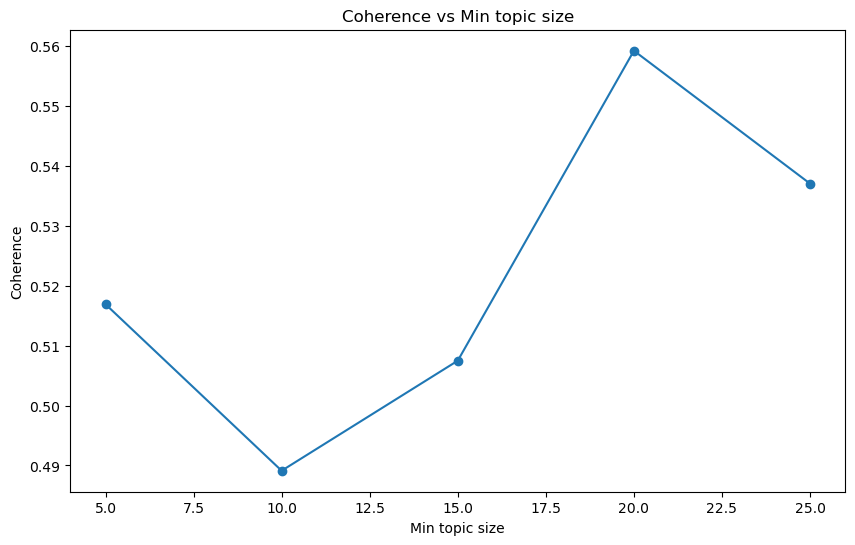

In [138]:
## Plot coherence score
# Define parameter range for min_cluster_size
min_cluster_sizes = range(5, 30, 5)
coherences = []
num_topics = []
min_clusters = []
uncategorized_topics = []

for min_cluster_size in min_cluster_sizes:
    # Get topic model
    topics, probs, topic_model = create_topic_model(documents, min_cluster_size, embeddings)

    # Get coherence and uncategorized topics
    coherence = calculate_coherence_score(topic_model, documents)
    uncategorized = topics.count(-1)

    # Append to list
    coherences.append(coherence)
    num_topics.append(len(set(topics)) - (1 if -1 in topics else 0))  # Number of topics
    min_clusters.append(min_cluster_size)
    uncategorized_topics.append(uncategorized)
    print(f"Min cluster size: {min_cluster_size}, Coherence: {coherence}, Number of uncategorized: {uncategorized}")

# save plot
plt.savefig('coherence_plot.png')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(min_clusters, coherences, marker='o')
plt.xlabel("Min topic size")
plt.ylabel("Coherence")
plt.title("Coherence vs Min topic size")
plt.show()

### Create optimal topic model and save

In [145]:
# choose topic size and run, this is the best model
topics, probs, topic_model = create_topic_model(documents, 15, embeddings)
topic_df = topic_model.get_topic_info()
topic_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,377,-1_ai_data_firms_intelligence,"[ai, data, firms, intelligence, digital, artif...",[■ Despite high hopes for artificial intellige...
1,0,191,0_workers_automation_labor_ai,"[workers, automation, labor, ai, growth, work,...",[The rapid development of artificial intellige...
2,1,98,1_financial_credit_ai_data,"[financial, credit, ai, data, banking, artific...",[Recent advances in machine learning (ML) and ...
3,2,96,2_ai_data_systems_public,"[ai, data, systems, public, intelligence, gove...",[The field of artificial intelligence (AI) is ...
4,3,56,3_ai_intelligence_artificial_business,"[ai, intelligence, artificial, business, study...",[Timely and accurate measurement of AI use by ...
5,4,52,4_chatgpt_generative_content_ai,"[chatgpt, generative, content, ai, students, l...",[Generative AI technology has revolutionized t...
6,5,34,5_firms_esg_corporate_earnings,"[firms, esg, corporate, earnings, information,...",[Using Artificial Intelligence (AI) techniques...
7,6,26,6_healthcare_medical_ai_health,"[healthcare, medical, ai, health, artificial, ...","[In this study, we examine some of the recent ..."
8,7,26,7_patent_ai_law_property,"[patent, ai, law, property, intellectual, inve...",[This chapter delves into the transformative p...
9,8,24,8_algorithm_trust_human_ai,"[algorithm, trust, human, ai, decision, algori...",[While artificial intelligence (AI) technologi...


###  Reduce outliers

Calculating initial topic assignments...
Found 377 outliers.
{-1: [('ai', 0.03370531768560586), ('data', 0.021473523374753015), ('firms', 0.01778996288780205), ('intelligence', 0.01594198989219103), ('digital', 0.01587668887479765), ('artificial', 0.01577762858038882), ('technology', 0.01473818826511422), ('human', 0.013046914762323211), ('impact', 0.012840482062749932), ('paper', 0.012549877164140242)], 0: [('workers', 0.03694511603588691), ('automation', 0.034604305290560994), ('labor', 0.03296492777652041), ('ai', 0.03200442930042573), ('growth', 0.026498540283144717), ('work', 0.022188774644815383), ('employment', 0.02216105971764559), ('jobs', 0.02101585855403005), ('occupations', 0.019776630522353157), ('job', 0.019229504200344187)], 1: [('financial', 0.0755411075633797), ('credit', 0.048841063602660655), ('ai', 0.03279431844978117), ('data', 0.02894214350167903), ('banking', 0.027205124703795113), ('artificial', 0.026749556872763952), ('intelligence', 0.0258619523751395), ('borr

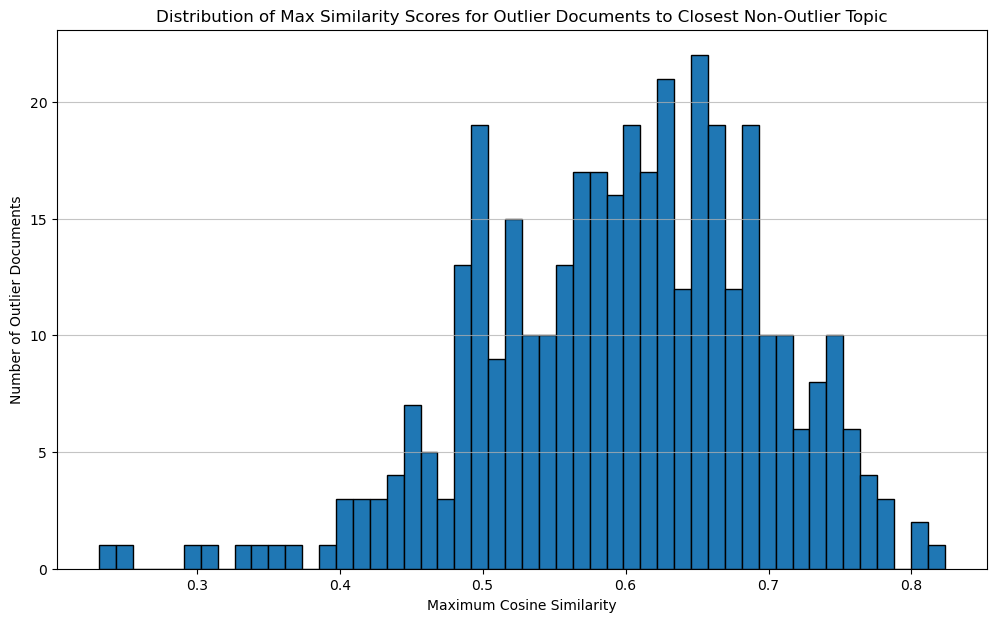


Descriptive Statistics for Maximum Similarities:
count    377.000000
mean       0.598477
std        0.098681
min        0.231779
25%        0.530237
50%        0.606984
75%        0.666186
90%        0.720896
95%        0.747605
99%        0.783504
max        0.823304
dtype: float64


In [146]:
print("Calculating initial topic assignments...")
# Get topics assigned before any outlier reduction attempts
initial_topics, _ = topic_model.transform(documents, embeddings=embeddings)

# 1. Identify outliers and their embeddings from the initial run
outlier_indices = np.where(np.array(initial_topics) == -1)[0]

if len(outlier_indices) > 0:
    print(f"Found {len(outlier_indices)} outliers.")
    outlier_embeddings = embeddings[outlier_indices]

    # 2. Get topic embeddings (corresponding to the initial topics)
    # Ensure topic_embeddings_ exists and is not empty
    if hasattr(topic_model, 'topic_embeddings_') and topic_model.topic_embeddings_ is not None and len(topic_model.topic_embeddings_) > 0:
        topic_embeddings = topic_model.topic_embeddings_
        
        # Filter out the outlier topic (-1) if it exists in topic_embeddings_
        topic_indices = [idx for idx in range(len(topic_embeddings)) 
                         if idx in topic_model.topic_representations_ and idx != -1]
        print(topic_model.topic_representations_)
        
        # Only use embeddings for actual topics (not the outlier topic)
        filtered_topic_embeddings = topic_embeddings[topic_indices]

        # 3. Calculate similarities between outliers and non-outlier topics
        print("Calculating similarities between outliers and non-outlier topics...")
        similarities = cosine_similarity(outlier_embeddings, filtered_topic_embeddings)

        # 4. Find maximum similarity for each outlier
        max_similarities = np.max(similarities, axis=1)

        # 5. Plot distribution
        print("Plotting similarity distribution...")
        plt.figure(figsize=(12, 7))
        plt.hist(max_similarities, bins=50, edgecolor='black')
        plt.title('Distribution of Max Similarity Scores for Outlier Documents to Closest Non-Outlier Topic')
        plt.xlabel('Maximum Cosine Similarity')
        plt.ylabel('Number of Outlier Documents')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

        # Print some descriptive statistics
        print("\nDescriptive Statistics for Maximum Similarities:")
        stats = pd.Series(max_similarities).describe(percentiles=[.25, .5, .75, .90, .95, .99])
        print(stats)

    else:
        print("Could not find valid topic embeddings in the model to compare against.")

else:
    print("No outliers found in the initial topic assignment.")

In [147]:
#  Choose threshold

for threshold in [0.55, 0.6, 0.65, 0.67, 0.68, 0.69, 0.7]:
    print("Threshold: ", threshold)
    #  Reduce outliers
    new_topics = topic_model.reduce_outliers(documents, topics, embeddings = embeddings, strategy="embeddings", threshold=threshold)

    # update
    topic_model.update_topics(documents, topics=new_topics)

    # calc coherence
    coherence = calculate_coherence_score(topic_model, documents)
    print("Coherence score: ", coherence)

    # Count the number of documents per topic
    topic_counts = pd.Series(new_topics).value_counts().sort_index()

    # Display the counts
    print("Number of documents per topic:")
    print(topic_counts)

2025-04-23 10:47:37,235 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Threshold:  0.55


2025-04-23 10:47:54,150 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.39276483746552865
Number of documents per topic:
-1     122
 0     238
 1     118
 2     156
 3      78
 4      67
 5      60
 6      29
 7      37
 8      55
 9      24
 10     32
Name: count, dtype: int64
Threshold:  0.6


2025-04-23 10:48:05,270 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.3941243446160593
Number of documents per topic:
-1     189
 0     228
 1     109
 2     143
 3      71
 4      63
 5      51
 6      29
 7      31
 8      49
 9      23
 10     30
Name: count, dtype: int64
Threshold:  0.65


2025-04-23 10:48:16,320 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.3954657663583378
Number of documents per topic:
-1     268
 0     218
 1     104
 2     120
 3      64
 4      56
 5      43
 6      27
 7      28
 8      42
 9      21
 10     25
Name: count, dtype: int64
Threshold:  0.67


2025-04-23 10:48:27,505 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.3847503333506724
Number of documents per topic:
-1     294
 0     213
 1     103
 2     115
 3      59
 4      55
 5      41
 6      27
 7      28
 8      38
 9      20
 10     23
Name: count, dtype: int64
Threshold:  0.68


2025-04-23 10:48:38,686 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.385324540716093
Number of documents per topic:
-1     302
 0     212
 1     103
 2     113
 3      58
 4      54
 5      39
 6      27
 7      28
 8      38
 9      20
 10     22
Name: count, dtype: int64
Threshold:  0.69


2025-04-23 10:48:49,756 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.38762448120118426
Number of documents per topic:
-1     319
 0     209
 1     101
 2     110
 3      58
 4      53
 5      38
 6      26
 7      27
 8      34
 9      20
 10     21
Name: count, dtype: int64
Threshold:  0.7
Coherence score:  0.38631882936250705
Number of documents per topic:
-1     329
 0     206
 1     101
 2     107
 3      58
 4      53
 5      37
 6      26
 7      27
 8      31
 9      20
 10     21
Name: count, dtype: int64


In [150]:
# choose topic size and run, this is the best model
topics, probs, topic_model = create_topic_model(documents, 15, embeddings)
new_topics = topic_model.reduce_outliers(documents, topics, embeddings = embeddings, strategy="embeddings", threshold=0.65)
topic_model.update_topics(documents, topics=new_topics, vectorizer_model=CountVectorizer(stop_words="english"))
topic_df = topic_model.get_topic_info()
topic_df.to_csv('topics_wp.csv')
topic_df

2025-04-23 10:52:20,070 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


,Topic,Count,Name,Representation,Representative_Docs
0,-1,268,-1_ai_data_digital_firms,"[ai, data, digital, firms, technology, artific...",[■ Despite high hopes for artificial intellige...
1,0,218,0_ai_workers_labor_automation,"[ai, workers, labor, automation, growth, emplo...",[The rapid development of artificial intellige...
2,1,104,1_financial_credit_ai_data,"[financial, credit, ai, data, artificial, bank...",[Recent advances in machine learning (ML) and ...
3,2,120,2_ai_data_intelligence_artificial,"[ai, data, intelligence, artificial, systems, ...",[The field of artificial intelligence (AI) is ...
4,3,64,3_ai_intelligence_artificial_study,"[ai, intelligence, artificial, study, business...",[Timely and accurate measurement of AI use by ...
5,4,56,4_chatgpt_generative_content_ai,"[chatgpt, generative, content, ai, students, l...",[Generative AI technology has revolutionized t...
6,5,43,5_investors_firms_returns_ai,"[investors, firms, returns, ai, stock, corpora...",[Using Artificial Intelligence (AI) techniques...
7,6,27,6_healthcare_medical_ai_health,"[healthcare, medical, ai, health, artificial, ...","[In this study, we examine some of the recent ..."
8,7,28,7_patent_ai_law_property,"[patent, ai, law, property, intellectual, inve...",[This chapter delves into the transformative p...
9,8,42,8_human_ai_algorithm_decision,"[human, ai, algorithm, decision, trust, algori...",[While artificial intelligence (AI) technologi...


In [151]:
# Check if necessary variables exist
required_vars = ['topics', 'new_topics', 'documents', 'topic_model', 'embeddings']
missing_vars = [var for var in required_vars if var not in locals() and var not in globals()]

if missing_vars:
    print(f"Error: One or more required variables not found: {missing_vars}")
    print("Please ensure the cell that defines the final model (e.g., execution_count 254) and earlier cells defining 'documents' and 'embeddings' have been run.")
else:
    print("Required variables found. Proceeding...")

    # Convert topics to numpy arrays for efficient comparison
    initial_topics_array = np.array(topics) # Using 'topics' from the final cell as initial
    final_topics_array = np.array(new_topics) # Using 'new_topics' from the final cell as final

    # 1. Find indices of initial outliers (using 'topics')
    initial_outlier_indices = np.where(initial_topics_array == -1)[0]

    # 2. Find indices of final non-outliers (using 'new_topics')
    final_non_outlier_indices = np.where(final_topics_array != -1)[0]

    # 3. Find indices of documents that *changed* from outlier to non-outlier
    changed_indices = np.array(list(set(initial_outlier_indices) & set(final_non_outlier_indices)))

    print(f"\nFound {len(changed_indices)} documents that were reassigned from outliers when applying the final threshold (0.7).")

    reassigned_data = [] # List to store data for CSV

    if len(changed_indices) > 0:
        print(f"Processing {len(changed_indices)} reassigned documents for CSV output...")

        # Ensure documents is indexable
        if not isinstance(documents, (list, np.ndarray, pd.Series)):
            print("Warning: 'documents' might not be in an easily indexable format. Trying to convert to list.")
            try:
                 documents_list = list(documents)
            except TypeError:
                 print("Error: Could not convert 'documents' to a list. Cannot include document text.")
                 documents_list = None
        else:
             documents_list = documents # Use as is if already suitable

        if documents_list is not None:
            for idx in changed_indices: # Process all changed indices
                original_topic = initial_topics_array[idx] # Should be -1
                new_topic = final_topics_array[idx]
                document_text_str = "[Error retrieving document text]" # Default
                topic_words_str = "[Error retrieving topic words]" # Default

                try:
                    # Handle potential conversion if documents is pandas Series vs list/array
                    if isinstance(documents_list, pd.Series):
                        try:
                            document_text_str = str(documents_list.iloc[idx])
                        except IndexError:
                             try:
                                  document_text_str = str(documents_list[idx])
                             except KeyError: pass # Keep default error message
                    else:
                         try:
                            document_text_str = str(documents_list[idx])
                         except IndexError: pass # Keep default error message
                except Exception as e:
                    document_text_str = f"[Error retrieving document text: {e}]"

                try:
                    # Use the FINAL topic_model instance to get words for the NEW topic
                    topic_words = topic_model.get_topic(new_topic)
                    if topic_words: # Check if topic_words is not False or None
                         topic_words_str = ", ".join([f"{word}({score:.3f})" for word, score in topic_words])
                    else:
                         topic_words_str = f"(Topic {new_topic} merged/removed/no words)"
                except ValueError as ve:
                     topic_words_str = f"(Topic {new_topic} invalid: {ve})"
                except Exception as e:
                    topic_words_str = f"(Error retrieving words: {e})"

                reassigned_data.append({
                    'Document Index': idx,
                    'Original Topic': original_topic,
                    'New Topic': new_topic,
                    'New Topic Keywords': topic_words_str,
                    'Document Text': document_text_str
                })
        else:
             print("Cannot process document details because 'documents' could not be processed.")

        # Create DataFrame and save to CSV
        if reassigned_data:
            reassigned_df = pd.DataFrame(reassigned_data)
            csv_filename = 'reassigned_outliers.csv'
            try:
                reassigned_df.to_csv(csv_filename, index=False)
                print(f"\nSuccessfully saved details of {len(reassigned_data)} reassigned documents to '{csv_filename}'")
            except Exception as e:
                print(f"\nError saving data to CSV '{csv_filename}': {e}")
        else:
            print("\nNo data collected to save to CSV.")


    elif len(initial_outlier_indices) > 0:
        print("\nNo documents were reassigned from outliers based on the final threshold application.")
        print(f"(There were {len(initial_outlier_indices)} outliers in the 'topics' variable before the final reduction).")
    else:
         print("\nThere were no initial outliers in the 'topics' variable to reassign.")

Required variables found. Proceeding...

Found 109 documents that were reassigned from outliers when applying the final threshold (0.7).
Processing 109 reassigned documents for CSV output...

Successfully saved details of 109 reassigned documents to 'reassigned_outliers.csv'


In [152]:
# Save the model
with open('wp_model.pkl', 'wb') as f:
    pickle.dump(topic_model, f)

print("Model saved successfully!")

Model saved successfully!


## Label topics and display paper and citation counts

### Label topics

In [159]:
# load model
with open('wp_model.pkl', 'rb') as f:
    topic_model = pickle.load(f)

# Load topics from the model
topics = topic_model.topics_
probs = topic_model.probabilities_

print(f"Loaded {len(topics)} papers and their probabilities from the model")

Loaded 1016 papers and their probabilities from the model


In [160]:
custom_topic_labels = {
    -1: "",
    0: "Automation and Labour",
    1: "Finance and Banking",
    2: "Policy, Systems and Global Governance",
    3: "Business Adoption",
    4: "Generative AI",
    5: "Investment and Capital",
    6: "Healthcare & Medicine",
    7: "Patents and Innovation",
    8: "Decision-Making",
    9: "Customer Service Chatbots",
    10: "Ethics and Bias"
}

topic_model.set_topic_labels(custom_topic_labels)

In [164]:
papers_topics = pd.DataFrame({'abstract': documents, 'Topic': topics, 'Probability': probs})
papers_topics = papers_topics.merge(data, on = "abstract", how = "inner")
papers_topics = papers_topics.rename(columns = {"abstract" : "abstract"})
papers_topics.to_csv('papers_topics_wp.csv')
papers_topics

,abstract,Topic,Probability,title,author,doi,link,year,Source,ID,abstract_short,citations
0,Do stronger intellectual property rights incen...,-1,0.000000,do stronger ipr incentivize female participati...,"higgins, matthew j",10.3386/w32547,http://www.nber.org/papers/w32547.pdf,2024.0,NBER,4,Do stronger intellectual property rights incen...,0.0
1,Drawing insights from the field of innovation ...,7,0.000000,"old moats for new models: openness, control, a...","nagaraj, abhishek",10.3386/w32474,http://www.nber.org/papers/w32474.pdf,2024.0,NBER,6,Drawing insights from the field of innovation ...,32.0
2,How will the emergence of ChatGPT and other fo...,0,1.000000,artificial intelligence and the skill premium,"veruete, mario",10.3386/w32430,http://www.nber.org/papers/w32430.pdf,2024.0,NBER,8,How will the emergence of ChatGPT and other fo...,19.0
3,David Ricardo initially believed machinery wou...,0,1.000000,learning from ricardo and thompson: machinery ...,"johnson, simon",10.3386/w32416,http://www.nber.org/papers/w32416.pdf,2024.0,NBER,11,David Ricardo initially believed machinery wou...,8.0
4,Timely and accurate measurement of AI use by f...,3,0.754018,tracking firm use of ai in real time: a snapsh...,"savage, keith",10.3386/w32319,http://www.nber.org/papers/w32319.pdf,2024.0,NBER,14,Timely and accurate measurement of AI use by f...,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1011,Can artificial intelligence (AI) assist human ...,4,0.649462,when and how artificial intelligence augments ...,"jia, nan, luo, xueming , fang, zheng, liao, ch...",10.2139/ssrn.4397280,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2023.0,SSRN,8686,Can artificial intelligence (AI) assist human ...,237.0
1012,This paper looks at transparency and fintech t...,1,0.743284,demystifying consumer-facing fintech: accounta...,"paterson, jeannie marie, miller, tim, lyons, h...",NaN,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2023.0,SSRN,8687,This paper looks at transparency and fintech t...,1.0
1013,The knowledge-based and data-driven economy re...,2,1.000000,digital trade: is data treaty-ready?,"ciuriak, dan",10.2139/ssrn.3110785,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2018.0,SSRN,8700,The knowledge-based and data-driven economy re...,42.0
1014,Credit risk is probably the most regulated app...,1,0.796437,credit risk and artificial intelligence: on th...,"bravo, cristián, calabrese, raffaella, lessman...",10.2139/ssrn.4615412,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2023.0,SSRN,8702,Credit risk is probably the most regulated app...,1.0


### Citations

In [165]:
topics_citations_sum = papers_topics[['Cited by', 'Topic']].groupby('Topic').sum().reset_index().rename(columns = {'Cited by':'sum_citations'})
topics_citations_average = papers_topics[['Cited by', 'Topic']].groupby('Topic').mean().reset_index().rename(columns = {'Cited by':'mean_citations'})
topics_citations_median = papers_topics[['Cited by', 'Topic']].groupby('Topic').median().reset_index().rename(columns = {'Cited by':'med_citations'})
topics_citations_max = papers_topics[['Cited by', 'Topic']].groupby('Topic').max().reset_index().rename(columns = {'Cited by':'max_citations'})

topics_citations = pd.merge(topics_citations_sum, topics_citations_average, on = 'Topic', how = 'inner')
topics_citations = pd.merge(topics_citations, topics_citations_median, on = 'Topic', how = 'inner')
topics_citations = pd.merge(topics_citations, topics_citations_max, on = 'Topic', how = 'inner')

topics_citations.sort_values('med_citations', ascending=False)

,Topic,sum_citations,mean_citations,med_citations,max_citations
10,9,2060.0,98.095238,17.0,558.0
9,8,1961.0,46.690476,11.0,333.0
1,0,19965.0,91.582569,8.0,1994.0
3,2,3587.0,29.891667,6.0,395.0
2,1,3487.0,33.528846,5.5,643.0
0,-1,6194.0,23.111940,4.0,622.0
7,6,398.0,14.740741,4.0,74.0
4,3,1812.0,28.312500,3.0,425.0
6,5,1798.0,41.813953,3.0,435.0
11,10,2444.0,97.760000,3.0,1687.0


## Extract research questions

In [22]:
# ## WRITE PROMPT

# prompt = "You are an academic expert in economics, finance, management and innovation studies. You are provided with abstracts from academic papers. Your goal is to carefully review each abstract to identify the main research question. Then, summarize this research question in less than 50 words."

# example1 = """The environmental effect of operating activities in the manufacturing industry is crucial to the sustainable development of the economy and society. Since we have entered the era of information explosion, the artificial intelligence has been involved to address the environmental problems caused by daily operations. This study examines the complex relation between artificial intelligence application and corporate environmental investment. The results show that: (1) AI application have a direct and positive impact on corporate environmental investment; (2) Managerial myopia plays a negative moderating role, inhibiting the positive effect of AI application on corporate environmental investment; (3) Companies' pollution emission mediates the relationship between AI application and corporate environmental investment. When reduced by AI application, a lower pollution emission will trigger a larger scale of corporate environmental investment; (4) Compared with under-valued companies and those in the Western region, AI application has a greater positive impact on the environmental investment of the over-valued companies and those in the East-Central region. By verifying the relationship between artificial intelligence applications and manufacturing enterprise investment, this study has a positive impact on promoting green innovation in the manufacturing industry and is of great significance for sustainable development strategies."""
# output1 = "What is the relationship between artificial intelligence application and corporate environmental investment?"

# example2 = "This paper explores the intersection between artificial intelligence and nuclear energy, shedding light on the intriguing scenario when these two sectors jointly consturct. Through the application of both full-sample and sub-sample methodologies, this study identifies the time-dependent interrelationships between China's artificial intelligence index (AI) and nuclear energy indicator (NUC). The quantitative analysis presents that AI's influence on nuclear energy is twofold. On one hand, AI contributes positively by acting as a catalyst and enhancing safety measures in the nuclear sector. On the other, the impact might be perceived negatively, primarily when cost-effective alternative energy sources overshadow the benefits of nuclear energy. Additionally, the positive effect of NUC on AI highlights the benefits derived from nuclear's expansive and consistent energy output, catering efficiently to AI's substantial energy demands. In essence, AI and NUC are found to be complementary, with each having the potential to propel the other forward. This reciprocity paves the way for a synergistic relationship, promising mutual benefits. The study introduces a fresh perspective on the co-evolution of energy and technology, offering thought-provoking recommendations aimed at cultivating the collaborative growth of AI and NUC towards a common good. Â© 2023"
# output2 = "What is the relationship between artificial intelligence and nuclear energy, and how do they influence each other's development?"

# example3 = "Fairness is a crucial concept in the context of artificial intelligence ethics and policy. It is an incremental component in existing ethical principle frameworks, especially for algorithm-enabled decision systems. Yet, translating fairness principles into context specific practices can be undermined by multiple unintended organisational risks. This paper argues that there is a gap between the potential and actual realized value of AI. Therefore, this research attempts to answer how organisations can mitigate AI risks that relate to unfair decision outcomes. We take a holistic view by analyzing the challenges throughout a typical AI product life cycle while focusing on the critical question of how rather broadly defined fairness principles may be translated into day-to-day practical solutions at the organizational level. We report on an exploratory case study of a social impact microfinance organization that is using AI-enabled credit scoring to support the screening process to particularly financially marginalized entrepreneurs. This paper highlights the importance of considering the strategic role of the organisation when developing and evaluating fair algorithm- enabled decision systems. The proposed framework and results of this study can be used to inspire the right questions that suit the context an organisation is situated in when implementing fair AI. Â© 2023, The Author(s), under exclusive license to Springer Nature Switzerland AG."
# output3 = "How can organizations translate broad fairness principles into practical solutions to mitigate AI-related risks in decision-making systems?"

# example4 = "The behavior of artificial intelligence (AI) algorithms is shaped by how they learn about their environment. We compare the prices generated by AIs that use different learning protocols when there is market interaction. Asynchronous learning occurs when the AI only learns about the return from the action it took. Synchronous learning occurs when the AI conducts counterfactuals to learn about the returns it would have earned had it taken an alternative action. The two lead to markedly different market prices. When future profits are not given positive weight by the AI, (perfect) synchronous updating leads to competitive pricing, while asynchronous can lead to pricing close to monopoly levels. We investigate how this result varies when either counterfactuals can only be calculated imperfectly and/or when the AI places a weight on future profits. Lastly, we investigate performance differences between offline and online play. Â© 2023 Wiley Periodicals LLC."
# output4 = "How do different AI learning protocols affect market pricing behavior, and what factors influence their competitive or monopolistic outcomes?"

In [23]:
# ## PROMPT GPT-4o mini

# from openai import OpenAI
# import time
# import logging
# from tqdm import tqdm
# import re
# from google.colab import userdata

# # set up logging
# logging.basicConfig(level = logging.INFO)

# # set up api
# api_key = userdata.get("OPENAI_API_KEY")
# client = OpenAI(api_key = api_key)

# # set up data dict
# data_dict = {
#         'abstract': [],
#         'Question': []
#     }

# # loop through abstracts
# for index, row in tqdm(papers_topics.iterrows(), desc = 'Processing abstracts'):
#     response = client.chat.completions.create(
#         model="gpt-4o-mini",
#         max_tokens=200,
#         temperature=0,
#         seed=2345,
#         messages=[
#             {"role": "system", "content": prompt},
#             {"role": "user", "content": example1},
#             {"role": "assistant", "content": output1},
#             {"role": "user", "content": example2},
#             {"role": "assistant", "content": output2},
#             {"role": "user", "content": example3},
#             {"role": "assistant", "content": output3},
#             {"role": "user", "content": example4},
#             {"role": "assistant", "content": output4},
#             {"role": "user", "content": row['abstract']}
#         ]
#     )

#     # store data in df
#     data_dict['abstract'].append(row['abstract'])
#     message = response.choices[0].message.content
#     data_dict['Question'].append(message)

# # Display the DataFrame
# questions = pd.DataFrame(data_dict)
# questions.to_csv('questions_pub.csv')
# questions

In [167]:
questions = pd.read_csv('questions_wps.csv', index_col = 0)
papers_topics = papers_topics.merge(questions, on = "abstract", how = "left")

In [25]:
papers_topics

,abstract,Topic,Probability,DOI,Cited by,Publication Year,title,author,Abstract_Short,Question
0,"For employees, work involves taking breaks as ...",-1,0.000000,10.4018/JOEUC.329596,1,2023,The Shape of Workbreaks to Come: Reframing Cyb...,Oravec J.A.,"For employees, work involves taking breaks as ...","How are AI methodologies and ""bossware"" platfo..."
1,The term 'artificial intelligence' (AI) refers...,1,0.000000,10.1109/ICONSTEM60960.2024.10568724,0,2024,A Novel Approach of Data-Driven Strategic Deci...,Umamaheswari S.; Valarmathi A.; Dhinakaran D.P...,The term 'artificial intelligence' (AI) refers...,What are the challenges and impacts of impleme...
2,This study aims to explore how firms' innovati...,-1,0.000000,10.1504/IJTM.2020.112122,5,2020,How to become the chosen one in the artificial...,Li J.; Liu Z.; Zhou J.,This study aims to explore how firms' innovati...,How does a firm's innovation performance influ...
3,This research aims to investigate the acceptan...,14,0.000000,10.4018/IJEBR.323796,0,2023,A Study of Customer Acceptance of Artificial I...,Choi Y.,This research aims to investigate the acceptan...,What factors influence customer acceptance of ...
4,Generative AI appears poised to transform whit...,5,0.630478,10.1145/3630106.3658987,0,2024,The Impact and Opportunities of Generative AI ...,Wolfe R.; Mitra T.,Generative AI appears poised to transform whit...,How does generative AI impact fact-checking or...
...,...,...,...,...,...,...,...,...,...,...
3588,"Since the introduction of ChatGPT, the leading...",5,0.839954,10.1016/j.jbusres.2024.114720,2,2024,Artificial intelligence and consumer behavior:...,Hermann E.; Puntoni S.,"Since the introduction of ChatGPT, the leading...",What is the impact of Generative Artificial In...
3589,IBM has deployed its Predictive Analytics for ...,0,0.866984,10.1287/INTE.2020.1064,1,2021,IBM predictive analytics reduces server downtime,Bogojeska J.; Giurgiu I.; Stark G.; Wiesmann D.,IBM has deployed its Predictive Analytics for ...,What are the results and effectiveness of IBM'...
3590,Natural resources have long been considered a ...,9,0.512194,10.1016/j.resourpol.2024.104831,0,2024,Nonlinear relationship between natural resourc...,Xie T.; Xu Y.; Li Y.,Natural resources have long been considered a ...,What is the nonlinear relationship between nat...
3591,Purpose: This study aims to explore the role t...,14,0.802057,10.1108/IJRDM-12-2022-0493,7,2023,The role of artificial intelligence in improvi...,Calvo A.V.; Franco A.D.; Frasquet M.,Purpose: This study aims to explore the role t...,What role do artificial intelligence systems p...


## Subtopic modeling

In [169]:
papers_topics

,abstract,Topic,Probability,title,author,doi,link,year,Source,ID,abstract_short,Cited by,Question
0,Do stronger intellectual property rights incen...,-1,0.000000,do stronger ipr incentivize female participati...,"higgins, matthew j",10.3386/w32547,http://www.nber.org/papers/w32547.pdf,2024.0,NBER,4,Do stronger intellectual property rights incen...,0.0,Do stronger intellectual property rights enhan...
1,Drawing insights from the field of innovation ...,7,0.000000,"old moats for new models: openness, control, a...","nagaraj, abhishek",10.3386/w32474,http://www.nber.org/papers/w32474.pdf,2024.0,NBER,6,Drawing insights from the field of innovation ...,32.0,How will the concepts of appropriability and c...
2,How will the emergence of ChatGPT and other fo...,0,1.000000,artificial intelligence and the skill premium,"veruete, mario",10.3386/w32430,http://www.nber.org/papers/w32430.pdf,2024.0,NBER,8,How will the emergence of ChatGPT and other fo...,19.0,"How will the emergence of AI, particularly Cha..."
3,David Ricardo initially believed machinery wou...,0,1.000000,learning from ricardo and thompson: machinery ...,"johnson, simon",10.3386/w32416,http://www.nber.org/papers/w32416.pdf,2024.0,NBER,11,David Ricardo initially believed machinery wou...,8.0,What are the complex effects of automation and...
4,Timely and accurate measurement of AI use by f...,3,0.754018,tracking firm use of ai in real time: a snapsh...,"savage, keith",10.3386/w32319,http://www.nber.org/papers/w32319.pdf,2024.0,NBER,14,Timely and accurate measurement of AI use by f...,23.0,What are the current and expected future rates...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,Can artificial intelligence (AI) assist human ...,4,0.649462,when and how artificial intelligence augments ...,"jia, nan, luo, xueming , fang, zheng, liao, ch...",10.2139/ssrn.4397280,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2023.0,SSRN,8686,Can artificial intelligence (AI) assist human ...,237.0,Can AI enhance employee creativity by assistin...
1012,This paper looks at transparency and fintech t...,1,0.743284,demystifying consumer-facing fintech: accounta...,"paterson, jeannie marie, miller, tim, lyons, h...",NaN,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2023.0,SSRN,8687,This paper looks at transparency and fintech t...,1.0,What are the implications of fintech tools for...
1013,The knowledge-based and data-driven economy re...,2,1.000000,digital trade: is data treaty-ready?,"ciuriak, dan",10.2139/ssrn.3110785,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2018.0,SSRN,8700,The knowledge-based and data-driven economy re...,42.0,What are the implications of the knowledge-bas...
1014,Credit risk is probably the most regulated app...,1,0.796437,credit risk and artificial intelligence: on th...,"bravo, cristián, calabrese, raffaella, lessman...",10.2139/ssrn.4615412,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2023.0,SSRN,8702,Credit risk is probably the most regulated app...,1.0,What are the divergences and commonalities in ...


In [171]:
for topic in range(0, len(topic_df)):
  papers = papers_topics[papers_topics['Topic'] == topic][['abstract', 'year', 'Cited by', 'doi', 'title', 'author', 'Question']]
  subdocuments = papers['abstract']
  subdocuments = subdocuments.reset_index(drop=True)
  subdocuments = subdocuments.tolist()
  if len(subdocuments) > 30:
    gc.collect()
    # Extract the embeddings for just the documents in this topic
    topic_indices = papers_topics[papers_topics['Topic'] == topic].index.tolist()
    topic_embeddings = embeddings[topic_indices]
    
    subtopics, subprobs, sub_topic_model = create_topic_model(subdocuments, 5, topic_embeddings)
    mini_df = pd.DataFrame({'abstract': subdocuments, 'Topic': subtopics})
    mini_df = mini_df.merge(papers, on = 'abstract', how = 'left')
    mini_df.to_csv(f'subtopics/subtopics_{topic}_papers.csv')
    mini_topic_df = sub_topic_model.get_topic_info()
    print(mini_topic_df)
    mini_topic_df.to_csv(f'subtopics/subtopics_{topic}.csv')

    Topic  Count                                       Name  \
0      -1     69             -1_ai_labor_automation_workers   
1       0     26        0_tax_technological_robots_economic   
2       1     23        1_occupations_jobs_years_automation   
3       2     17     2_technologies_occupations_exposure_er   
4       3     17          3_growth_ai_economic_connectivity   
5       4     17              4_work_workers_regulation_law   
6       5     13                      5_ai_job_skills_firms   
7       6     12  6_innovation_firms_analytics_productivity   
8       7     10                    7_ai_tasks_drivers_task   
9       8      7           8_wages_workers_complexity_tasks   
10      9      7        9_unemployment_industrial_big_tools   

                                       Representation  \
0   [ai, labor, automation, workers, intelligence,...   
1   [tax, technological, robots, economic, social,...   
2   [occupations, jobs, years, automation, risk, w...   
3   [technologi

In [172]:
def combine_subtopic_papers(base_path):
    # Define the pattern to match all subtopic paper files
    pattern = os.path.join(base_path, "subtopics_*_papers.csv")

    # Get all matching files
    file_paths = glob.glob(pattern)

    # Create an empty list to store individual dataframes
    all_dfs = []

    # Process each file
    for file_path in file_paths:
        # Extract the main topic number from the filename
        filename = os.path.basename(file_path)
        main_topic = int(filename.split('_')[1])

        # Read the CSV
        df = pd.read_csv(file_path, index_col=0)

        # read topic df description
        topic_df = pd.read_csv(f'subtopics/subtopics_{main_topic}.csv', index_col = 0)
        topic_df = topic_df[['Topic', 'Name']]
        topic_df = topic_df.rename(columns = {'Name': 'subtopic name'})

        # merge with labels
        df = df.merge(topic_df, on = 'Topic', how = 'left')

        # Add a column for the main topic
        df['broad_topic'] = main_topic

        # Append to our list
        all_dfs.append(df)

    # Concatenate all dataframes
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        return combined_df
    else:
        print("No files found matching the pattern.")
        return None

# Usage
base_directory = 'subtopics/'
papers_subtopics = combine_subtopic_papers(base_directory)

# Save the combined dataframe
if papers_subtopics is not None:
    output_path = os.path.join(base_directory, 'papers_subtopics.csv')
    papers_subtopics = papers_subtopics.rename(columns = {'Topic': 'subtopic'})
    papers_subtopics = papers_subtopics[['abstract', 'subtopic', 'subtopic name']]
    papers_subtopics.to_csv(output_path)
    print(f"Combined dataframe saved to {output_path}")
    print(f"Shape of combined dataframe: {papers_subtopics.shape}")

Combined dataframe saved to subtopics/papers_subtopics.csv
Shape of combined dataframe: (647, 3)


In [173]:
papers_subtopics

,abstract,subtopic,subtopic name
0,Timely and accurate measurement of AI use by f...,2,2_ai_firms_use_business
1,We study the early adoption and diffusion of f...,2,2_ai_firms_use_business
2,We introduce a new survey module intended to c...,2,2_ai_firms_use_business
3,This qualitative multiple-case study aims to e...,-1,-1_ai_intelligence_artificial_study
4,Purpose - This paper aims to articulate determ...,-1,-1_ai_intelligence_artificial_study
...,...,...,...
642,"As a new general-purpose technology, robots ha...",-1,-1_ai_labor_automation_workers
643,We create and validate a new measure of an occ...,-1,-1_ai_labor_automation_workers
644,Artificial intelligence and robotics (AI/R) ha...,-1,-1_ai_labor_automation_workers
645,Economists have often viewed the adoption of a...,-1,-1_ai_labor_automation_workers


In [175]:
papers_topics_full = papers_topics.merge(papers_subtopics, on = ['abstract'], how = 'left')
papers_topics_full.to_csv('papers_topics_full.csv')
papers_topics_full

,abstract,Topic,Probability,title,author,doi,link,year,Source,ID,abstract_short,Cited by,Question,subtopic,subtopic name
0,Do stronger intellectual property rights incen...,-1,0.000000,do stronger ipr incentivize female participati...,"higgins, matthew j",10.3386/w32547,http://www.nber.org/papers/w32547.pdf,2024.0,NBER,4,Do stronger intellectual property rights incen...,0.0,Do stronger intellectual property rights enhan...,NaN,NaN
1,Drawing insights from the field of innovation ...,7,0.000000,"old moats for new models: openness, control, a...","nagaraj, abhishek",10.3386/w32474,http://www.nber.org/papers/w32474.pdf,2024.0,NBER,6,Drawing insights from the field of innovation ...,32.0,How will the concepts of appropriability and c...,NaN,NaN
2,How will the emergence of ChatGPT and other fo...,0,1.000000,artificial intelligence and the skill premium,"veruete, mario",10.3386/w32430,http://www.nber.org/papers/w32430.pdf,2024.0,NBER,8,How will the emergence of ChatGPT and other fo...,19.0,"How will the emergence of AI, particularly Cha...",8.0,8_wages_workers_complexity_tasks
3,David Ricardo initially believed machinery wou...,0,1.000000,learning from ricardo and thompson: machinery ...,"johnson, simon",10.3386/w32416,http://www.nber.org/papers/w32416.pdf,2024.0,NBER,11,David Ricardo initially believed machinery wou...,8.0,What are the complex effects of automation and...,-1.0,-1_ai_labor_automation_workers
4,Timely and accurate measurement of AI use by f...,3,0.754018,tracking firm use of ai in real time: a snapsh...,"savage, keith",10.3386/w32319,http://www.nber.org/papers/w32319.pdf,2024.0,NBER,14,Timely and accurate measurement of AI use by f...,23.0,What are the current and expected future rates...,2.0,2_ai_firms_use_business
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,Can artificial intelligence (AI) assist human ...,4,0.649462,when and how artificial intelligence augments ...,"jia, nan, luo, xueming , fang, zheng, liao, ch...",10.2139/ssrn.4397280,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2023.0,SSRN,8686,Can artificial intelligence (AI) assist human ...,237.0,Can AI enhance employee creativity by assistin...,-1.0,-1_ai_generative_chatgpt_effect
1012,This paper looks at transparency and fintech t...,1,0.743284,demystifying consumer-facing fintech: accounta...,"paterson, jeannie marie, miller, tim, lyons, h...",NaN,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2023.0,SSRN,8687,This paper looks at transparency and fintech t...,1.0,What are the implications of fintech tools for...,2.0,2_financial_inclusion_fintech_data
1013,The knowledge-based and data-driven economy re...,2,1.000000,digital trade: is data treaty-ready?,"ciuriak, dan",10.2139/ssrn.3110785,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2018.0,SSRN,8700,The knowledge-based and data-driven economy re...,42.0,What are the implications of the knowledge-bas...,1.0,1_data_economy_economic_trade
1014,Credit risk is probably the most regulated app...,1,0.796437,credit risk and artificial intelligence: on th...,"bravo, cristián, calabrese, raffaella, lessman...",10.2139/ssrn.4615412,https://papers.ssrn.com/sol3/papers.cfm?abstra...,2023.0,SSRN,8702,Credit risk is probably the most regulated app...,1.0,What are the divergences and commonalities in ...,-1.0,-1_models_model_financial_risk


## Visualisations

In [176]:
# Add labels

topic_df['Label'] = topic_df['Topic'].apply(lambda x: custom_topic_labels[x])
topic_df.to_csv('topics_wps.csv')
topic_df

,Topic,Count,Name,Representation,Representative_Docs,Label
0,-1,268,-1_ai_data_digital_firms,"[ai, data, digital, firms, technology, artific...",[■ Despite high hopes for artificial intellige...,
1,0,218,0_ai_workers_labor_automation,"[ai, workers, labor, automation, growth, emplo...",[The rapid development of artificial intellige...,Automation and Labour
2,1,104,1_financial_credit_ai_data,"[financial, credit, ai, data, artificial, bank...",[Recent advances in machine learning (ML) and ...,Finance and Banking
3,2,120,2_ai_data_intelligence_artificial,"[ai, data, intelligence, artificial, systems, ...",[The field of artificial intelligence (AI) is ...,"Policy, Systems and Global Governance"
4,3,64,3_ai_intelligence_artificial_study,"[ai, intelligence, artificial, study, business...",[Timely and accurate measurement of AI use by ...,Business Adoption
5,4,56,4_chatgpt_generative_content_ai,"[chatgpt, generative, content, ai, students, l...",[Generative AI technology has revolutionized t...,Generative AI
6,5,43,5_investors_firms_returns_ai,"[investors, firms, returns, ai, stock, corpora...",[Using Artificial Intelligence (AI) techniques...,Investment and Capital
7,6,27,6_healthcare_medical_ai_health,"[healthcare, medical, ai, health, artificial, ...","[In this study, we examine some of the recent ...",Healthcare & Medicine
8,7,28,7_patent_ai_law_property,"[patent, ai, law, property, intellectual, inve...",[This chapter delves into the transformative p...,Patents and Innovation
9,8,42,8_human_ai_algorithm_decision,"[human, ai, algorithm, decision, trust, algori...",[While artificial intelligence (AI) technologi...,Decision-Making


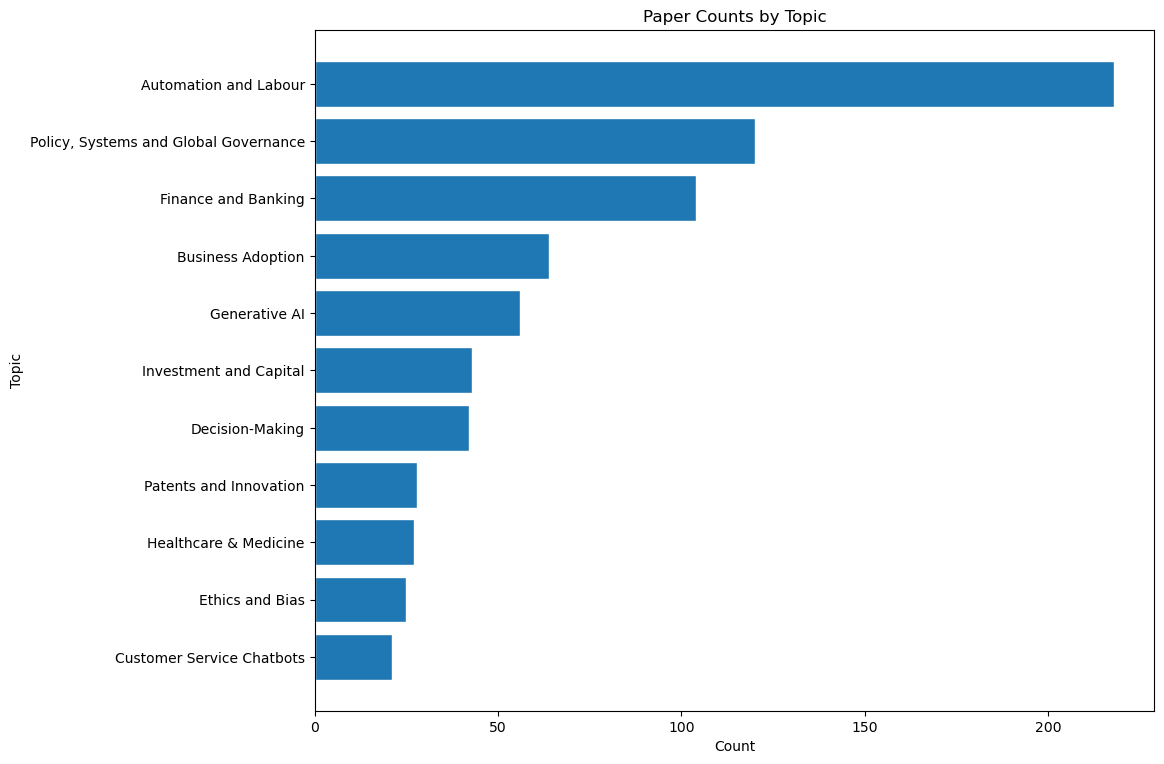

In [181]:
# Paper counts by topic

# Filter out the '-1' topic
proper_topics = topic_df[topic_df['Topic'] != -1]

# Sort by count (topic size)
proper_topics = proper_topics.sort_values('Count', ascending=True)

# Creating the bar chart
plt.figure(figsize=(12, 8))
plt.barh(proper_topics['Label'], proper_topics['Count'], edgecolor="white")
plt.xlabel("Count")
plt.ylabel("Topic")
plt.title("Paper Counts by Topic")
plt.tight_layout(pad=2)

# Saving the figure to a file
file_path = "images/wp_counts.pdf"
plt.savefig(file_path, format="pdf", bbox_inches="tight")
plt.show()

In [32]:
fig = topic_model.visualize_barchart(topics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], custom_labels = True)
fig.show()
fig.write_image("images/pub_bars.pdf")

In [182]:
## Hierarchy

from scipy.cluster import hierarchy as sch

# Hierarchical topics
# linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(documents)

topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 10/10 [00:00<00:00, 774.17it/s]


In [183]:
fig = topic_model.visualize_topics(custom_labels = True)
fig.show()
fig.write_image("images/wp_intertopic_distances.pdf")

In [184]:
fig = topic_model.visualize_heatmap(topics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], custom_labels = True, width = 800, height = 600)
fig.show()
fig.write_image("images/wp_similarity_matrix.pdf")

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Define your list of target words
target_words = ['adoption', 'innovation', 'work', 'business', 'ethical', 'responsible', 'regulation', 'chatgpt'] # Add/remove words as needed

scores_per_topic_list = []

try:
    # Check if custom_topic_labels is defined
    if 'custom_topic_labels' not in locals() or not isinstance(custom_topic_labels, dict):
        raise NameError("Please define the 'custom_topic_labels' dictionary in the cell above.")

    c_tf_idf_matrix = topic_model.c_tf_idf_
    vocab_list = list(topic_model.vectorizer_model.get_feature_names_out())
    vocab_dict = {word: i for i, word in enumerate(vocab_list)}

    word_indices = {}
    found_words = []
    not_found_words = []
    for word in target_words:
        idx = vocab_dict.get(word)
        if idx is not None:
            word_indices[word] = idx
            found_words.append(word)
        else:
            not_found_words.append(word)

    if not_found_words:
        print(f"Warning: Words not found in vocabulary and will be skipped: {not_found_words}")

    if not found_words:
        print("Error: None of the target words were found in the vocabulary.")
    else:
        all_topic_ids = sorted(list(topic_model.get_topic_freq().Topic.unique()))
        if -1 in all_topic_ids:
            all_topic_ids.remove(-1)

        index_offset = 1 if -1 in topic_model.get_topic_freq().Topic.unique() else 0

        # Use custom_topic_labels for Topic Name
        for topic_id in all_topic_ids:
            topic_index = topic_id + index_offset

            if 0 <= topic_index < c_tf_idf_matrix.shape[0]:
                # *** Use custom label, fallback if topic_id not in dict ***
                topic_name = custom_topic_labels.get(topic_id, f"Topic {topic_id} (Custom label missing)")
                topic_data = {"Topic ID": topic_id, "Topic Name": topic_name}

                for word in found_words:
                    word_index = word_indices[word]
                    score = c_tf_idf_matrix[topic_index, word_index]
                    topic_data[word] = score

                scores_per_topic_list.append(topic_data)
            else:
                print(f"Warning: Topic index {topic_index} (for Topic ID {topic_id}) is out of bounds.")

        scores_df = pd.DataFrame(scores_per_topic_list)

        print(f"c-TF-IDF Scores for words {found_words} across all topics:")

        # --- Styling the DataFrame ---
        styled_df_to_render = None
        table_html = "" # Initialize table_html
        try:
            if not scores_df.empty:
                # *** Use 'Topic Name' (which now contains custom labels) as index ***
                df_to_style = scores_df.set_index('Topic Name')
                df_to_style = df_to_style[found_words]
                cmap = plt.get_cmap('Blues')
                format_dict = {word: "{:.4f}" for word in found_words}

                # Apply styling (gradient, format). Font is handled via CSS wrapper.
                styled_result = df_to_style.style.background_gradient(cmap=cmap, axis=0, subset=found_words) \
                                             .format(format_dict) \
                                             .set_properties(**{'text-align': 'right'}) # Align text right for scores

                styled_df_to_render = styled_result
                # Get the HTML for the table part
                table_html = styled_df_to_render.to_html()
            else:
                print("DataFrame is empty, nothing to style or save.")

        except Exception as style_error:
             print(f"Error during styling: {style_error}")
             styled_df_to_render = None
             table_html = ""


        # --- Display and Save ---
        if styled_df_to_render and table_html:
            print("Attempting to display styled DataFrame...")
            try:
                display(styled_df_to_render) # Display in Jupyter if possible

                # --- Construct Full HTML Document with Roboto Font and Save ---
                output_html_filename = 'styled_topic_word_scores_roboto.html'
                full_html = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>Styled Topic Word Scores</title>
    <link href="https://fonts.googleapis.com/css2?family=Roboto:wght@400;700&display=swap" rel="stylesheet">
    <style>
        body {{
            font-family: 'Roboto', sans-serif;
            margin: 20px; /* Add some margin */
        }}
        table {{
            border-collapse: collapse; /* Nicer borders */
            margin: auto; /* Center table if desired */
            /* The Styler object usually adds its own table styles,
               but you can add overrides here if needed */
        }}
        th, td {{
            padding: 8px 12px; /* Add padding to cells */
            text-align: right; /* Default alignment */
        }}
        th {{
             background-color: #f2f2f2; /* Light grey header */
             font-weight: bold;
        }}
        /* Align the index (Topic Name) left */
        th.row_heading, td.row_heading {{
             text-align: left;
        }}

    </style>
</head>
<body>
    {table_html}
</body>
</html>
"""
                try:
                    print(f"Attempting to save full HTML document to {output_html_filename}...")
                    with open(output_html_filename, 'w', encoding='utf-8') as f:
                        f.write(full_html)
                    print(f"Successfully saved styled table with Roboto font to {output_html_filename}")
                except Exception as export_error:
                    print(f"Error saving styled DataFrame as HTML: {export_error}")

            except Exception as display_error:
                 print(f"Error displaying styled DataFrame: {display_error}")

        elif scores_df.empty and found_words:
             print("No scores to display or save (DataFrame was empty).")
        elif not found_words:
             print("No words found, nothing to display or save.")


except NameError as e:
     # Specific check for the custom labels dictionary
     if 'custom_topic_labels' in str(e):
         print("Error: 'custom_topic_labels' dictionary is not defined.")
         print("Please define it in the 'User Configuration' section of this cell.")
     else:
          print(f"NameError: {e}")
except AttributeError as e:
    if 'topic_model' in str(e) and 'c_tf_idf_' in str(e):
         print(f"Error: Could not access necessary attributes (like c_tf_idf_) from 'topic_model'. Is the model loaded and fitted correctly? Details: {e}")
    else:
         print(f"AttributeError: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


c-TF-IDF Scores for words ['adoption', 'innovation', 'work', 'business', 'ethical', 'responsible', 'regulation', 'chatgpt'] across all topics:
Attempting to display styled DataFrame...


,adoption,innovation,work,business,ethical,responsible,regulation,chatgpt
Topic Name,,,,,,,,
Automation and Labour,0.0087,0.0075,0.0202,0.0027,0.0006,0.0000,0.0041,0.0012
Finance and Banking,0.0079,0.0064,0.0013,0.0044,0.0076,0.0052,0.0124,0.0004
"Policy, Systems and Global Governance",0.0078,0.0146,0.0045,0.0058,0.0131,0.0060,0.0102,0.0003
Business Adoption,0.0135,0.0097,0.0090,0.0312,0.0040,0.0017,0.0000,0.0000
Generative AI,0.0045,0.0011,0.0088,0.0050,0.0049,0.0026,0.0007,0.0664
Investment and Capital,0.0099,0.0088,0.0010,0.0044,0.0000,0.0000,0.0012,0.0187
Healthcare & Medicine,0.0106,0.0074,0.0044,0.0035,0.0105,0.0016,0.0102,0.0013
Patents and Innovation,0.0000,0.0270,0.0037,0.0000,0.0034,0.0000,0.0011,0.0000
Decision-Making,0.0229,0.0000,0.0041,0.0052,0.0039,0.0000,0.0009,0.0009


Attempting to save full HTML document to styled_topic_word_scores_roboto.html...
Successfully saved styled table with Roboto font to styled_topic_word_scores_roboto.html


In [199]:
docs_df = pd.DataFrame({'abstract': documents})
docs_cits = docs_df.merge(data[['abstract', 'Cited by', 'year']], on = 'abstract', how = 'left')[['abstract', 'Cited by', 'year']]
docs_cits

,abstract,Cited by,year
0,Do stronger intellectual property rights incen...,0.0,2024.0
1,Drawing insights from the field of innovation ...,32.0,2024.0
2,How will the emergence of ChatGPT and other fo...,19.0,2024.0
3,David Ricardo initially believed machinery wou...,8.0,2024.0
4,Timely and accurate measurement of AI use by f...,23.0,2024.0
...,...,...,...
1011,Can artificial intelligence (AI) assist human ...,237.0,2023.0
1012,This paper looks at transparency and fintech t...,1.0,2023.0
1013,The knowledge-based and data-driven economy re...,42.0,2018.0
1014,Credit risk is probably the most regulated app...,1.0,2023.0


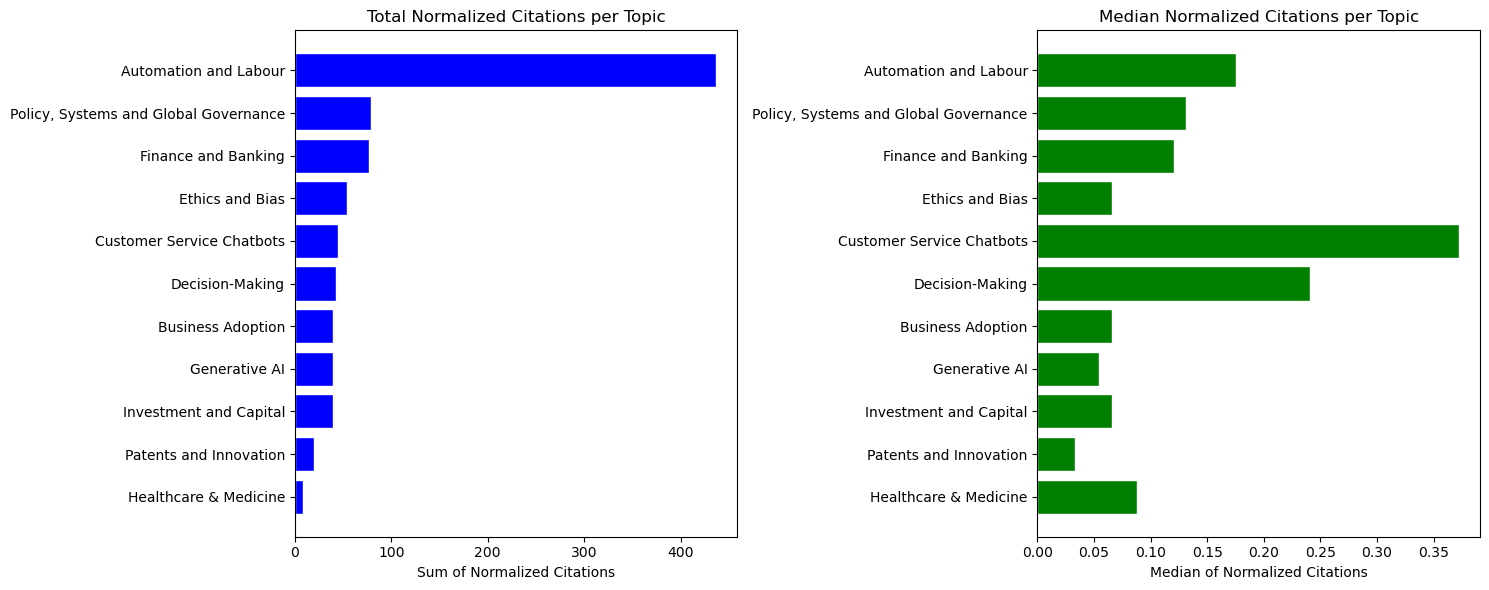

In [205]:
# find average citations
avg_citations = docs_cits['Cited by'].mean()

# Calculate normalized citations
docs_cits['normalized_citations'] = docs_cits['Cited by'] / avg_citations

# Merge with topic citations
docs_cits = docs_cits.merge(papers_topics[['abstract', 'Topic']], on='abstract', how='left')

# create a new topics_citations dataframe with normalized values
topics_normalized_citations = docs_cits.groupby('Topic').agg(
    sum_norm_citations=('normalized_citations', 'sum'),
    med_norm_citations=('normalized_citations', 'median'),
    count=('normalized_citations', 'count')
).reset_index()

# Apply labels
topics_normalized_citations['Label'] = topics_normalized_citations['Topic'].apply(lambda x: custom_topic_labels[x])
topics_normalized_citations = topics_normalized_citations[(topics_normalized_citations['Topic'] <= 10) &
                                                         (topics_normalized_citations['Topic'] != -1)]
topics_normalized_citations = topics_normalized_citations.sort_values(by='sum_norm_citations', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Total Normalized Citations bar chart
axes[0].barh(topics_normalized_citations['Label'], topics_normalized_citations['sum_norm_citations'],
            color='blue', edgecolor="white")
axes[0].set_title("Total Normalized Citations per Topic")
axes[0].set_xlabel("Sum of Normalized Citations")
axes[0].invert_yaxis()  # Invert y-axis for better readability

# Median Normalized Citations bar chart
axes[1].barh(topics_normalized_citations['Label'], topics_normalized_citations['med_norm_citations'],
            color='green', edgecolor="white")
axes[1].set_title("Median Normalized Citations per Topic")
axes[1].set_xlabel("Median of Normalized Citations")
axes[1].invert_yaxis()  # Ensure both y-axes match

# Adjust layout and save
plt.tight_layout()
plt.show()

file_path_norm_cits = "images/wp_normalized_citations_by_topic.pdf"
fig.savefig(file_path_norm_cits, format="pdf", bbox_inches="tight")

In [211]:
# Get the top 5 papers from Topic 9 (Decision-Making) by citation count
top_papers = papers_topics_full[papers_topics_full['Topic'] == 9].sort_values(by='Cited by', ascending=False).head()

# Display the full abstracts along with other information
pd.set_option('display.max_colwidth', None)  # Ensure full text display
display(top_papers[['abstract', 'Cited by', 'Question', 'subtopic', 'subtopic name']])
pd.reset_option('display.max_colwidth')  # Reset to default

,abstract,Cited by,Question,subtopic,subtopic name
193,"Purpose – Robots are predicted to have a profound impact on the service sector. The emergenceof robots has attracted increasing interest from business scholars and practitioners alike. In this article, we undertake a systematic review of the business literature about the impact of service robots on customers and employees with the objective of guiding future research. Design/methodology/approach – We analyzed the literature on service robots as they relate to customers and employees in business journals listed in the Financial Times top 50 journals plus all journals covered in the cross-disciplinary SERVSIG literature alerts.Findings – The analysis of the identified studies yielded multiple observations about the impact of service robots on customers (e.g., overarching frameworks on acceptance and usage of service robots; characteristics of service robots and anthropomorphism; and potential for enhanced and deteriorated service experiences) and service employees (e.g., employee benefits such as reduced routine work, enhanced productivity and job satisfaction; potential negative consequences such as loss of autonomy and a range of negative psychological outcomes; opportunities for human-robot collaboration; job insecurity; and robot-related upskilling and development requirements). We also conclude that current research on service robots is fragmented, is largely conceptual in nature, and focused on the initial adoption stage. We feel that more research is needed to build an overarching theory. In addition, more empirical research is needed, especially on the long(er)- term usage service robots on actual behaviors, the well-being, and potential downsides and (ethical) risks for customers and service employees.Research limitations – Our review focused on the business and service literature. Future work may want to include additional literature streams, including those in computer science, engineering, and information systems.Originality/value – This article is the first to synthesize the business and service literature on the impact of service robots on customers and employees.",558.0,"What is the impact of service robots on customers and employees in the service sector, and what gaps exist in the current research on this topic?",NaN,NaN
402,"Robots and artificial intelligence (AI) technologies are becoming more prominent in the tourism industry. Nowadays, consumers are faced with multiple options involving both human and robot interactions. A series of experimental studies were implemented. Four experiments demonstrated that consumers had a more positive attitude toward robot-staffed (vs. human-staffed) hotels when COVID-19 was salient. The results were different from previous studies, which were conducted before the COVID-19 pandemic. Since the moderating role of perceived threat in consumers’ preference for robot-staffed hotels was significant, the respondents’ preference was attributed to the global health crisis. This research provides a number of theoretical and managerial implications by improving the understanding of technology acceptance during a health crisis.Full paper available at https://doi-org/10.1016/j.ijhm.2020.102795",543.0,How does the perceived threat of COVID-19 influence consumer attitudes toward robot-staffed hotels compared to human-staffed hotels in the tourism industry?,NaN,NaN
443,"Companies from the travel, tourism and hospitality industry have started adopting robots, artificial intelligence and service automation technologies (RAISA) in their operations. Self-check-in kiosks, robotic pool cleaners, delivery robots, robot concierges, chatbots, etc., are used increasingly by tourism companies and transform the ways they create and deliver services. This paper investigates the impact of RAISA technologies on travel, tourism and hospitality companies – their operations, facilities design, marketing, supply chain management, human resource managemen

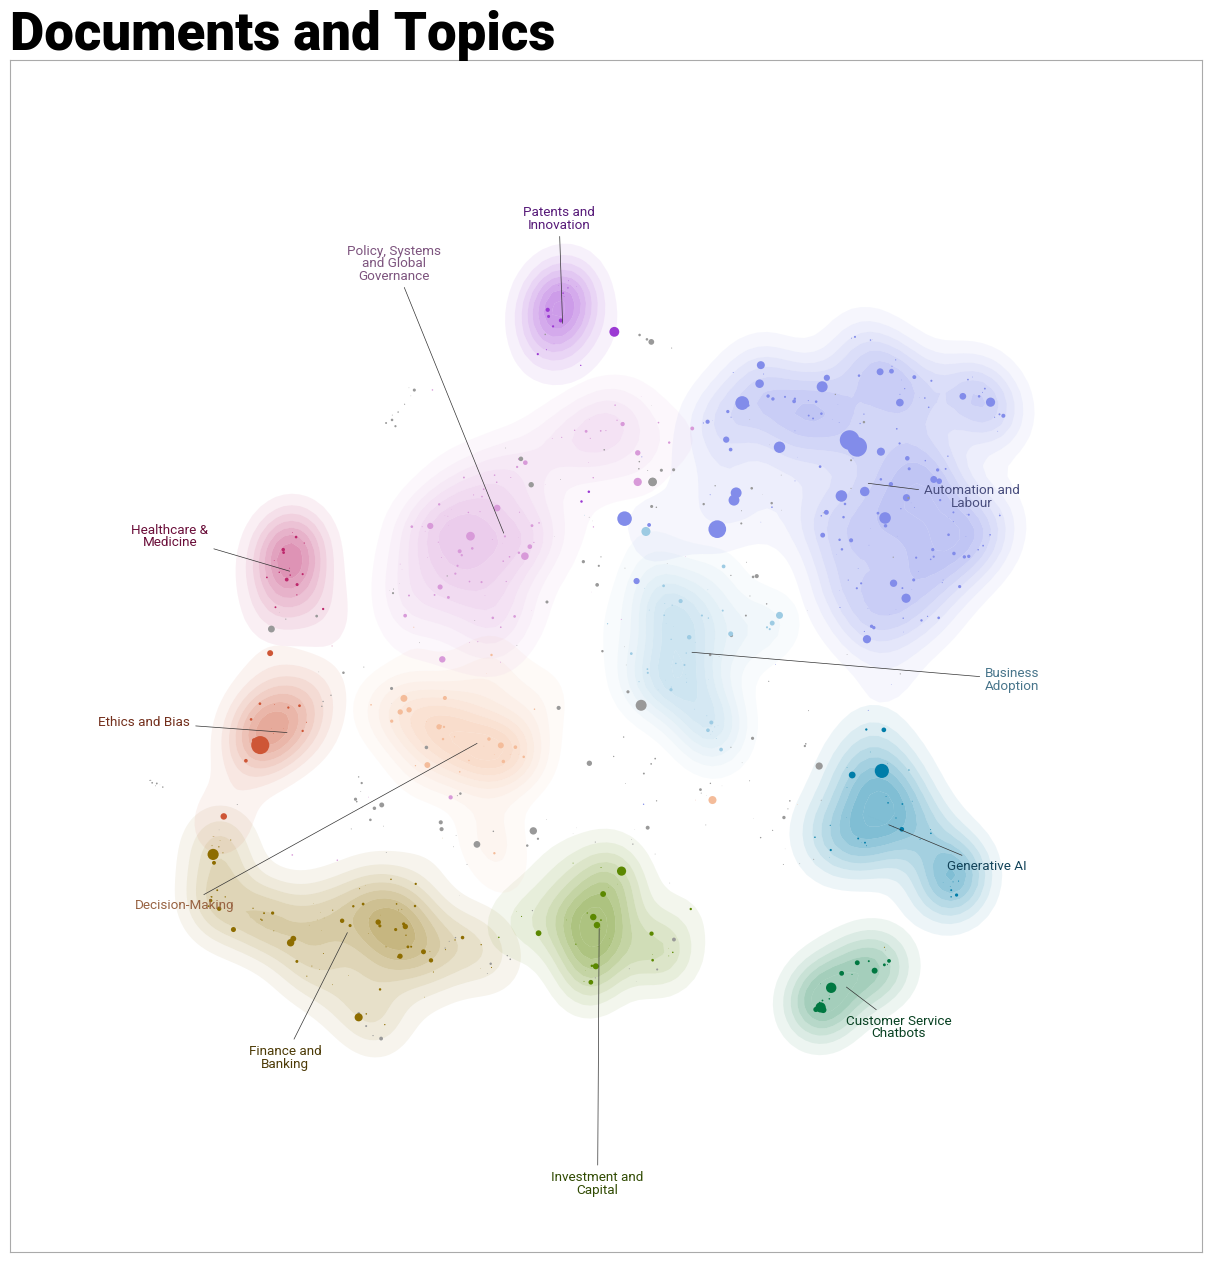

In [212]:
citations = docs_cits['Cited by'].to_list()
scaled_citations = [2*(c / max(citations)) * 100 for c in citations]
fig = topic_model.visualize_document_datamap(documents, custom_labels = True, embeddings=embeddings, point_size=scaled_citations)
fig.show()
fig.savefig("images/wp_landscape.pdf", dpi=600, bbox_inches='tight')